# Przygotowanie danych tekstowych

W poniższym notatniku skupimy się głównie na przygotowaniu danych tekstowych - ich wektoryzacji, ekstrakcji cechy i czyszczeniu. Następnie przejdziemy do budowy modelu regresji logistycznej.

Cały plik stanowi efekt postępów w projekcie pomiędzy 24.03.2022 a 21.04.2022. Najważniejsze punkty:
1. Normalizacja tekstu
2. Usunięcie z tekstu tzw. *stop words*
3. Stemming tekstu za pomocą pakietu *SnowballStemmer*
4. Lematyzacja słów komentarzy z użyciem biblioteki *spaCy*
5. Wektoryzacja:
    * aspekty teoretyczne (*Bag of words*, *N_gram*)
    * wektoryzacja z użyciem pakietu TfidfVectorizer
    * wektoryzacja alternatywna - stworzenie tensorów dwuwymiarowych w postaci zmiennych binarnych (eksperyment)


6. Zdefiniowanie modelu regresji logistycznej dopasowany do problemu multiklasyfikacji.
7. Uczenie modelu dla danych będących na różnych etapach przetworzenia, w tym:
    - tekst po normalizacji
    - tekst po usunięciu tzw. *stop words*
    - tekst po stemmingu lub po lematyzacji


8. Predykcja modelów na zbiorze testowym i porównanie jej efektywności za pomocą różnych współczynników.

In [1]:
#wczytanie podstawowych pakietów
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv') #wczytanie zbioru danych

In [3]:
train.drop(axis = 1, labels = "id", inplace = True) #id komentarzy nie będą nam potrzebne w dalszej klasyfikacji

In [4]:
train.head() 

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
#podział na zmienne objaśniające i objaśniane
X_train = train.comment_text
y_train = train.drop(axis = 1, labels = "comment_text")

In [6]:
X_train 

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [7]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


##  Stop words, normalizacja, stemming, lematyzacja

In [8]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

## Normalizacja
Normalizacja tekstu polega na takim jego przetworzeniu, aby miał spójną formę, która ułatwi dalszą interpretację tekstu (przykłady: zmiana liter na małe bądź wielkie, rozwinięcie skrótów, normalizacja skrótowców, konwersja wyrażeń numerycznych i wyrażeń słowno-numerycznych do postaci słownej, normalizacja znaków specjalnych – takich jak symbol akapitu czy znak zastrzeżenia prawa autorskiego, usunięcie lub zmiana znaków interpunkcyjnych itd.).


In [9]:
#kod do normalizacji
print("I\r\r\r\r'am")

'am


In [10]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    
    return text

In [11]:
X_train = X_train.apply(clean_text)

In [12]:
X_train[:10]
print(X_train)

0         explanation why the edits made under my userna...
1         daww he matches this background colour i am se...
2         hey man i am really not trying to edit war it ...
3          more i cannot make any real suggestions on im...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself   that is a ...
159568    spitzer   umm theres no actual article for pro...
159569    and it looks like it was actually you who put ...
159570     and  i really do not think you understand  i ...
Name: comment_text, Length: 159571, dtype: object


## Stop words
Są to najczęściej występujące słowa języka, które na ogół nie niosą ze sobą żadnych istotnych treści. Są zatem zazwyczaj usuwane w celu optymalizacji modelu.

W celu wykrycia i usunięcia wspomnianych słów skorzystamy z biblioteki *spaCy*, a konkretnie z anglojęzycznego pakietu *STOP_WORDS*.

In [13]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

#nltk.download('stopwords')
nlp = English()
# "nlp" Obiekt służy do tworzenia dokumentów z adnotacjami lingwistycznymi

def stop_words_remove(text):
    nlp_doc = nlp(text)

    #tworzymi listę tokenów z przetwarzanego tekstu
    tokens = []
    for token in nlp_doc:
        tokens.append(token.text)

    # usuwamy 'stop words' i tworzymy nową listę tokenów
    filtered_tokens =[] 

    for word in tokens:
        word_id = nlp.vocab[word]
        if word_id.is_stop == False:
            filtered_tokens.append(word)
    
    filtered_comment = ' '.join(filtered_tokens) 
    
    return filtered_comment

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Przykład działania**

In [14]:
X_train[8]

'sorry if the word nonsense was offensive to you anyway i am not intending to write anything in the articlewow they would jump on me for vandalism i am merely requesting that it be more encyclopedic so one can use it for school as a reference i have been to the selective breeding page but it is almost a stub it points to animal breeding which is a short messy article that gives you no info there must be someone around with expertise in eugenics '

In [15]:
stop_words_remove(X_train[8])

'sorry word nonsense offensive intending write articlewow jump vandalism merely requesting encyclopedic use school reference selective breeding page stub points animal breeding short messy article gives info expertise eugenics'

**Usunięcie '*stop words*' ze zbioru treningowego**

In [16]:
X_train_stop = X_train.apply(stop_words_remove)
X_train_stop

0         explanation edits username hardcore metallica ...
1         daww matches background colour seemingly stuck...
2         hey man trying edit war guy constantly removin...
3           real suggestions improvement   wondered sect...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                ashamed    horrible thing talk page  
159568    spitzer    umm s actual article prostitution r...
159569      looks like actually speedy version deleted look
159570        think understand   came idea bad right awa...
Name: comment_text, Length: 159571, dtype: object

## Stemming 
Stemming jest procesem usunięcia końcówki fleksyjnej ze słowa, w  czego efekcie pozostaje tylko temat wyrazu. 


In [17]:
sn = SnowballStemmer(language='english')


def stemmer(text):
    words =  text.split()
    train = [sn.stem(word) for word in words if not word in set(stopwords.words('english'))]
    return ' '.join(train)

In [18]:
X_train_stem = X_train_stop.apply(stemmer)

In [19]:
# żeby uniknąć każdorazowego uruchamiania stemmingu zapisujemy wynikową tabelę do pliku .csv
# X_train_stem = pd.DataFrame(X_train_stem)
# X_train_stem.to_csv('X_train_stem.csv') 

In [20]:
# stem_csv = pd.read_csv('X_train_stem.csv')['comment_text']
# stem_csv

## Lematyzacja

Lematyzacja to sprowadzenie słowa do jego podstawowej postaci. Na przykład w przypadku czasownika to najczęściej będzie bezokolicznik, w przypadku rzeczownika sprowadzamy do mianownika liczby pojedynczej.

In [21]:
import spacy


#budujemy model
#NER - Named Entity Recognition - wyłączamy
#'parser' daje informacje składniowe - póki co ich nie potrzebujemy. 
# https://spacy.io/usage/linguistic-features#disabling

# Wyłączenie parsera sprawi, że SpaCy będzie ładował się i działał znacznie szybciej
# https://spacy.io/usage/linguistic-features#named-entities
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

def lemmatization(text):
    text_model = load_model(text)
    result = " ".join([token.lemma_ for token in text_model])
    return result

In [22]:
X_train_lem = X_train_stop.apply(lemmatization)

**Przykład działania**

In [23]:
X_train_stop[0]

'explanation edits username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac remove template talk page retired'

In [24]:
X_train_lem[0]

'explanation edit username hardcore metallica fan revert vandalism closure gas vote new york doll fac remove template talk page retire'

In [25]:
# żeby uniknąć każdorazowego uruchamiania funkcji z lematyzacją zapisujemy wynikową tabelę do pliku .csv
# X_train_lemm = pd.DataFrame(X_train_lem)
# X_train_lemm.to_csv('X_train_lem.csv') 

## Wektoryzacja

Na początku przedstawimy kilka podstawowych pojęć związanych z przetwarzaniem języka naturalnego.
### „Bag of words” 
Aby algorytm mógł sobie poradzić z tekstem, musimy najpierw podzielić ten tekst na mniejsze fragmenty. Stworzenie tzw. "worka słów" jest jednym ze sposób na uzyskanie takiego podziału. Każde słowo użyte w tekście zostaje wyodrębnione i wrzucone do multizbioru. Dla przykładu, jeśli mamy dwa zdania: „Marcin ma kota.” oraz „Patryk ma psa.”, to w worku słów znajdzie się pięć słów: Marcin, ma, kota, Patryk, psa. Ich kolejność nie będzie odgrywała roli.


### N_gram
W naszym worku mogą się znaleźć nietylko pojedyńcze słowa, ale pewne sekwencje słów. N-gram jest ciągiem elementów z danej próbki tekstu bądź mowy. Zazwyczaj jednym elementem jest pojedyncze słowo (ale w określonych przypadkach mogą też być to fonemy, litery lub sylaby).

### Wektoryzacja

Z "bag of words" blisko związanym terminem jest wektoryzacjia. Najprostszym wektoryzatorem jest CountVectorizer. Zlicza on liczbę wystąpień każdego wyrazu (lub n_gramu) w tekście i przedstawia za pomocą wektora składającego się z liczb naturalnych. Każda liczba informuje, ile razy dany element wystąpił w analizowanym tekście.

Przykładem innego wektoryzatora, który rozpatrywaliśmy w naszym projekcie, jest wektoryzator TF-IDF. Opiera się on na metodzie obliczania wagi słów w oparciu o liczbę ich wystąpień w całym zbiorze jak i w pojedyńczych dokumentach.

$$\text{Dla termu }t_i\text{ w dokumencie }d_j\text{ mamy:}$$

$$(tf-idf)_{i,j} = (tf)_{i,j} \times (idf)_{i}$$
gdzie:

$(tf)_{i,j}-$ term frequency, liczba wystąpień termu $t_i$ w dokumencie $d_j$ podzielona przez liczbę wszystkich termów w $d_j.$

$(idf)_i-$ inverse document frequency, $(idf)_i = ln\left( \dfrac{|D|}{|\{j\ : f_i \in d_j\}|} \right)$ - gdzie $D$ to zbiór wszystkich dokumentów.


In [26]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode', #normalizacja tekstu, usuwanie akcentów itp. unicode jest wolniejsza, ale radzi sobie z dowolnymi znakami   
    token_pattern=r'\w{1,}',  #co zaliczamy jako token - tutaj są to obiekty typu r'\w' czyli o kategorii alfabetonumerycznej, o długości 1 lub większej   
    ngram_range=(1, 3),      #liczba możliwych n-gramów - tutaj dopuszczamy mono-, bi-, i tri-gramy  
    stop_words='english', #jaka kategoria dla stopwords, domyślnie jest None, dostępna jest opcja 'english' lub inna własna lista
    sublinear_tf=True) #zamiast term frequency (tf) oddaje 1+ln(tf)


In [27]:
word_vectorizer_basic = word_vectorizer
word_vectorizer_basic.fit(X_train)
X_train_transformed = word_vectorizer_basic.transform(X_train)

In [30]:
word_vectorizer_stop = word_vectorizer
word_vectorizer_stop.fit(X_train_stop)
X_train_stop_transformed = word_vectorizer_stop.transform(X_train_stop)

In [31]:
word_vectorizer_stem = word_vectorizer
word_vectorizer_stem.fit(X_train_stem)
X_train_stem_transformed = word_vectorizer_stem.transform(X_train_stem)

In [32]:
word_vectorizer_lem = word_vectorizer
word_vectorizer_lem.fit(X_train_lem)
X_train_lem_transformed = word_vectorizer_lem.transform(X_train_lem)

In [33]:
print(X_train_transformed[1])

  (0, 6048811)	0.08034046234044398
  (0, 5657981)	0.22482565382989295
  (0, 5657940)	0.1279446858802597
  (0, 5650041)	0.0680924444125307
  (0, 5554984)	0.2151597556837971
  (0, 5554982)	0.19859404078686696
  (0, 5552001)	0.055480697237542426
  (0, 5417567)	0.232497908811692
  (0, 5417566)	0.232497908811692
  (0, 5417204)	0.136113412161602
  (0, 5030487)	0.232497908811692
  (0, 5030486)	0.232497908811692
  (0, 5030249)	0.14934566279844375
  (0, 3424079)	0.232497908811692
  (0, 3424078)	0.232497908811692
  (0, 3424051)	0.13724967787894
  (0, 2892413)	0.13885693462322307
  (0, 2891410)	0.11528669465092176
  (0, 1380502)	0.232497908811692
  (0, 1380501)	0.232497908811692
  (0, 1380500)	0.232497908811692
  (0, 1045380)	0.232497908811692
  (0, 1045379)	0.232497908811692
  (0, 1045140)	0.15131336749531227
  (0, 508480)	0.232497908811692
  (0, 508479)	0.232497908811692
  (0, 508274)	0.12379787673557346


źródła: https://www.statystyczny.pl/klasyfikacja-tekstu-text-classification/

### Wektoryzacja - tensor ze zmiennymi binarnymi

Alternatywnym sposobem wektoryzacji będzie stworzenie tensora ze zmiennymi zero-jedynkowymi. Każda z nich odpowiada za wystąpienie bądź niewystąpienie danego słowa w danym komentarzu. Postać binarna macierzy powinna zapobiec problemowi zbyt dużej złożoności obliczeniowej.

Jednak żeby uniknąć macierzy o zbyt dużych wymiarach wybierzemy jedynie 1000 najczęściej występujących słów w zbiorze. 

In [34]:
full_text = ' '.join(list(X_train_lem))
full_text = full_text.split()
words = pd.DataFrame(full_text).value_counts()

In [33]:
words_5000 = words.rename_axis(['word'])\
            .reset_index()\
            .rename(columns={0:'count'})\
            .sort_values(by=['count'], ascending=False)

words_sequence = words_5000.loc[0:5000,'word'].values
words_sequence

array(['article', 'page', 'edit', ..., 'abroad', 'fl', 'danish'],
      dtype=object)

In [34]:
def vectorize_sequences(dataset, sequences, dimension=1000):
    results = np.zeros(shape = (dataset.shape[0], dimension), dtype=int)
    for j in range(dataset.shape[0]):
        for i,sequence in enumerate(sequences[0:1000]):
            if sequence in dataset[j]:
                results[j,i] = 1
                
    return results

In [35]:
#X_train_vect_bin = vectorize_sequences(X_train_bin_vect, list(words_sequence))

# Modele - eksperymenty & implementacja

In [35]:
#pakiety do budowania modelu
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV

### One vs Rest Classifier
Strategia one-vs-rest również znana jako one-vs-all polega na dopasowaniu oddzielnych modeli do każdej klasy - tzn. budujemy n modeli regresji liniowej dla problemu klasyfikacji binarnej z klasami "klasa n" oraz "inne klasy"

### Regresja logistyczna

W naszym modelu używamy solvera *saga* w LogisticRegression(). Solver ten o wiele szybciej radzi sobie z dużymi zbiorami danych oraz z problemami multiclass. Parametr *C*, który dobieramy za pomocą GridSearch(), jest odwrotności siły regularyzacji l2 w modelu.


Poniżej tworzymy trzy modele na podstawie zbiorów po różnych etapach obróki wstępnej. 

### Grid Search
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/grid_search.html


In [36]:
#dopasowujemy model do naszych danych

y_train1, y_test1 = train_test_split(y_train, test_size=0.2, shuffle = False)
X_train_transformed1, X_test_transformed1 = train_test_split(X_train_transformed, test_size=0.2, shuffle = False)
X_train_lem_transformed1, X_test_lem_transformed1 = train_test_split(X_train_lem_transformed, test_size=0.2, shuffle = False)
X_train_stem_transformed1, X_test_stem_transformed1 = train_test_split(X_train_stem_transformed, test_size=0.2, shuffle = False)


In [37]:
y_train1

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
127651,0,0,0,0,0,0
127652,0,0,0,0,0,0
127653,0,0,0,0,0,0
127654,1,0,0,0,1,1


In [38]:
list = np.arange(1,5, step = 1)

In [39]:
#szukamy najlepszych parametrów za pomocą GridSearch

parameters = {'estimator__C': list}
multi_logistic = OneVsRestClassifier(LogisticRegression(solver = 'saga', penalty = 'l2'))
clf = GridSearchCV(multi_logistic, parameters)


In [40]:
from sklearn.metrics import accuracy_score

In [40]:
clf.fit(X_train_transformed1, y_train1)
clf.get_params()
accuracy_score(clf.predict(X_test_transformed1), y_test1)

{'cv': None,
 'error_score': nan,
 'estimator__estimator__C': 1.0,
 'estimator__estimator__class_weight': None,
 'estimator__estimator__dual': False,
 'estimator__estimator__fit_intercept': True,
 'estimator__estimator__intercept_scaling': 1,
 'estimator__estimator__l1_ratio': None,
 'estimator__estimator__max_iter': 100,
 'estimator__estimator__multi_class': 'auto',
 'estimator__estimator__n_jobs': None,
 'estimator__estimator__penalty': 'l2',
 'estimator__estimator__random_state': None,
 'estimator__estimator__solver': 'saga',
 'estimator__estimator__tol': 0.0001,
 'estimator__estimator__verbose': 0,
 'estimator__estimator__warm_start': False,
 'estimator__estimator': LogisticRegression(solver='saga'),
 'estimator__n_jobs': None,
 'estimator': OneVsRestClassifier(estimator=LogisticRegression(solver='saga')),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'estimator__C': array([1, 2, 3, 4])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring'

In [42]:
clf.fit(X_train_lem_transformed1, y_train1)
clf.get_params()
accuracy_score(clf.predict(X_test_lem_transformed1), y_test1)

0.9151809493968354

In [43]:
clf.fit(X_train_stem_transformed1, y_train1)
clf.get_params()
accuracy_score(clf.predict(X_test_stem_transformed1), y_test1)

0.9156822810590631

In [ ]:
clf.fit(X_train_transformed1, y_train1)
clf.get_params()

## Model dla pełnego zbioru treningowego

In [41]:
test_raw = pd.read_csv('test.csv') #wczytanie zbioru danych
#test.drop(axis = 1, labels = "id", inplace = True) #id komentarzy nie będą nam potrzebne w dalszej klasyfikacji
test_raw.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [42]:
test_raw.shape, train.shape  #podobna liczba wierszy w zbiorze treningowym i testowym

((153164, 2), (159571, 7))

In [43]:
test_raw

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [44]:
test_labels = pd.read_csv('test_labels.csv') #wczytanie zbioru danych
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [45]:
test = test_raw.merge(test_labels, left_on = 'id', right_on='id')
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


Wartości -1 oznaczają, że obserwacje nie są brane pod uwagę

In [46]:
X_test_raw = test['comment_text']
y_test_raw = test.iloc[:,2:]

In [47]:
y_test = y_test_raw[(y_test_raw['toxic']!=-1) & (y_test_raw['severe_toxic']!=-1) &
                   (y_test_raw['obscene']!=-1) & (y_test_raw['threat']!=-1) &
                   (y_test_raw['insult']!=-1) & (y_test_raw['identity_hate']!=-1)].reset_index().drop(axis = 1, labels = "index")

X_test = X_test_raw[(y_test_raw['toxic']!=-1) & (y_test_raw['severe_toxic']!=-1) &
                   (y_test_raw['obscene']!=-1) & (y_test_raw['threat']!=-1) &
                   (y_test_raw['insult']!=-1) & (y_test_raw['identity_hate']!=-1)]

In [48]:
y_test.shape, X_test.shape

((63978, 6), (63978,))

In [49]:
X_test

5         Thank you for understanding. I think very high...
7                          :Dear god this site is horrible.
11        "::: Somebody will invariably try to add Relig...
13        " \n\n It says it right there that it IS a typ...
14        " \n\n == Before adding a new product to the l...
                                ...                        
153150    :Jerome, I see you never got around to this…! ...
153151    ==Lucky bastard== \n http://wikimediafoundatio...
153154    ==shame on you all!!!== \n\n You want to speak...
153155    MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...
153156    " \n\n == Unicorn lair discovery == \n\n Suppo...
Name: comment_text, Length: 63978, dtype: object

In [50]:
X_test = X_test.apply(clean_text)

In [51]:
X_test_stop = X_test.apply(stop_words_remove)

In [55]:
X_test_stop

5         thank understanding think highly revert discus...
7                                    dear god site horrible
11          somebody invariably try add religion     mea...
13             says right type type institution needed c...
14              adding new product list sure relevant   ...
                                ...                        
153150    jerome got   m surprised looked example    nom...
153151    lucky bastard    httpwikimediafoundationorgwik...
153154                  shame     want speak gays romanians
153155    mel gibson nazi bitch makes shitty movies butt...
153156          unicorn lair discovery      supposedly u...
Name: comment_text, Length: 63978, dtype: object

In [53]:
X_test_lem = X_test_stop.apply(lemmatization)

In [54]:
X_test_stem = X_test_stop.apply(stemmer)

### Wektoryzacja tekstu

In [60]:
word_vectorizer_basic.fit(X_train)
X_test_transformed = word_vectorizer_basic.transform(X_test)

word_vectorizer_stop.fit(X_train_stop)
X_test_stop_transformed = word_vectorizer_stop.transform(X_test_stop)

word_vectorizer_lem.fit(X_train_lem)
X_test_lem_transformed = word_vectorizer_lem.transform(X_test_lem)

word_vectorizer_stem.fit(X_train_stem)
X_test_stem_transformed = word_vectorizer_stem.transform(X_test_stem)

### Budowa modelu na pełnych danych treningowych

In [61]:
y_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
63973,0,0,0,0,0,0
63974,0,0,0,0,0,0
63975,0,0,0,0,0,0
63976,1,0,1,0,1,0


In [62]:
list = np.arange(1,5, step = 1)

In [64]:
parameters = {'estimator__C': list}
multi_logistic = OneVsRestClassifier(LogisticRegression(solver = 'saga', penalty = 'l2'))

In [65]:
clf_basic = GridSearchCV(multi_logistic, parameters)
clf_basic.fit(X_train_transformed, y_train)
clf_basic.get_params()
acc_basic = accuracy_score(clf_basic.predict(X_test_transformed), y_test)

In [66]:
basic_pred = clf_basic.predict(X_test_transformed)
basic_pred

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [67]:
from sklearn.metrics import multilabel_confusion_matrix

In [68]:
y_test.columns.values

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

In [69]:
multilabel_confusion_matrix(basic_pred, y_test)
                           #labels=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

array([[[54336,  1268],
        [ 3552,  4822]],

       [[63120,   176],
        [  491,   191]],

       [[58776,   982],
        [ 1511,  2709]],

       [[63662,   137],
        [  105,    74]],

       [[58966,  1084],
        [ 1585,  2343]],

       [[63019,   381],
        [  247,   331]]], dtype=int64)

In [70]:
acc_basic

0.8805683203601238

In [71]:
X_train_stop_transformed.shape, y_test.shape

((159571, 6379268), (63978, 6))

In [72]:
clf_stop = GridSearchCV(multi_logistic, parameters)
clf_stop.fit(X_train_stop_transformed, y_train)
clf_stop.get_params()
acc_stop = accuracy_score(clf_stop.predict(X_test_stop_transformed), y_test)

In [73]:
stop_pred = clf_stop.predict(X_test_stop_transformed)

In [74]:
multilabel_confusion_matrix(stop_pred, y_test) 

array([[[54288,  1260],
        [ 3600,  4830]],

       [[63125,   176],
        [  486,   191]],

       [[58763,   967],
        [ 1524,  2724]],

       [[63663,   137],
        [  104,    74]],

       [[58928,  1066],
        [ 1623,  2361]],

       [[63026,   381],
        [  240,   331]]], dtype=int64)

In [75]:
clf_lem = GridSearchCV(multi_logistic, parameters)
clf_lem.fit(X_train_lem_transformed, y_train)
clf_lem.get_params()
acc_lem = accuracy_score(clf_lem.predict(X_test_lem_transformed), y_test)

In [76]:
lem_pred = clf_lem.predict(X_test_lem_transformed)

In [77]:
multilabel_confusion_matrix(lem_pred, y_test)

array([[[54133,  1133],
        [ 3755,  4957]],

       [[63118,   178],
        [  493,   189]],

       [[58674,   909],
        [ 1613,  2782]],

       [[63646,   147],
        [  121,    64]],

       [[58843,  1011],
        [ 1708,  2416]],

       [[63003,   362],
        [  263,   350]]], dtype=int64)

In [78]:
clf_stem = GridSearchCV(multi_logistic, parameters)
clf_stem.fit(X_train_stem_transformed, y_train)
clf_stem.get_params()
acc_stem = accuracy_score(clf_stem.predict(X_test_stem_transformed), y_test)

In [79]:
stem_pred = clf_stem.predict(X_test_stem_transformed)

In [204]:
multilabel_confusion_matrix(stem_pred, y_test)

array([[[54112,  1126],
        [ 3776,  4964]],

       [[63136,   183],
        [  475,   184]],

       [[58671,   909],
        [ 1616,  2782]],

       [[63652,   146],
        [  115,    65]],

       [[58815,  1010],
        [ 1736,  2417]],

       [[62997,   359],
        [  269,   353]]], dtype=int64)

In [81]:
acc_basic, acc_stop, acc_lem, acc_stem

(0.8805683203601238, 0.8802244521554284, 0.879005283066054, 0.8783956985213667)

### Inny sposób wektoryzacji - CountVectorizer

*CountVectorizer* zlicza ilość wystąpień danych tokenów w zmiennej tekstowej i tworzy macierz (zazwyczaj jest to macierz rzadka), której element przedstawia liczbę wystąpień danego tokenu.

Implementacja tego algorytmu tworzy reprezentację *sparse* przy użyciu *scipy.sparse.csr_matrix*, która umożliwia efektywne działanie na macierzy zarówno pod względem obliczniowym, jak i pamięciowym.

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

vect_count = CountVectorizer()

In [83]:
X_train_lem_count = vect_count.fit_transform(X_train_lem)
X_test_lem_count = vect_count.transform(X_test_lem)

In [84]:
clf_lem2 = GridSearchCV(multi_logistic, parameters)
clf_lem2.fit(X_train_lem_count, y_train)
clf_lem2.get_params()
acc_lem2 = accuracy_score(clf_lem2.predict(X_test_lem_count), y_test)

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

In [85]:
X_test_lem_count.shape

(63978, 200895)

In [86]:
lem2_pred = clf_lem2.predict(X_test_lem_count)

In [218]:
multilabel_confusion_matrix(lem2_pred, y_test) #duzo mniej tagów przewiduje --> wiecej true negatives, mało true positives

array([[[57728,  4697],
        [  160,  1393]],

       [[63555,   330],
        [   56,    37]],

       [[60207,  2825],
        [   80,   866]],

       [[63763,   210],
        [    4,     1]],

       [[60429,  2973],
        [  122,   454]],

       [[63262,   702],
        [    4,    10]]], dtype=int64)

In [196]:
np.sum(lem2_pred, axis=0)

array([1551,   93,  945,    5,  576,   14])

In [202]:
np.sum(lem_pred, axis=0)

array([8712,  682, 4395,  185, 4124,  613])

In [201]:
np.sum(np.array(y_test) != np.zeros(6), axis=0)

array([6090,  367, 3691,  211, 3427,  712])

In [107]:
clf_lem2.predict(X_test_lem_count).shape

(63978, 6)

In [108]:
acc_lem, acc_lem2 #poprawa dokladnosci

(0.879005283066054, 0.9065303698146238)

In [109]:
clf_lem2.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__estimator__C': 1.0,
 'estimator__estimator__class_weight': None,
 'estimator__estimator__dual': False,
 'estimator__estimator__fit_intercept': True,
 'estimator__estimator__intercept_scaling': 1,
 'estimator__estimator__l1_ratio': None,
 'estimator__estimator__max_iter': 100,
 'estimator__estimator__multi_class': 'auto',
 'estimator__estimator__n_jobs': None,
 'estimator__estimator__penalty': 'l2',
 'estimator__estimator__random_state': None,
 'estimator__estimator__solver': 'saga',
 'estimator__estimator__tol': 0.0001,
 'estimator__estimator__verbose': 0,
 'estimator__estimator__warm_start': False,
 'estimator__estimator': LogisticRegression(solver='saga'),
 'estimator__n_jobs': None,
 'estimator': OneVsRestClassifier(estimator=LogisticRegression(solver='saga')),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'estimator__C': array([1, 2, 3, 4])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring'

### Ręcznie ustawione wartości parametrów dla zdefiniowanego wcześniej modelu regresji logistycznej

In [116]:
log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=73, max_iter=1000)

In [117]:
one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train_lem_count, y_train)

C:\Users\patry\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=10, max_iter=1000,
                                                 random_state=73,
                                                 solver='liblinear'))

In [118]:
lem3_pred_proba = one_vs_rest.predict_proba(X_test_lem_count)
roc_auc_score_test = roc_auc_score(y_test, lem3_pred_proba,average='weighted')
acc3_lem = accuracy_score(one_vs_rest.predict(X_test_lem_count), y_test)

In [119]:
lem3_pred = one_vs_rest.predict(X_test_lem_count)

In [121]:
acc3_lem

0.881334208634218

In [122]:
roc_auc_score_test

0.9454684318351347

### Ważone klasy

Już na wcześniejszych etapach realizacji projektu, zauważyliśmy, że liczność obserwacji należących do jakiejkolwiek klasy oraz nienależących do żadnej z klas, jest niezbalansowana. Podjęliśmy więc próbę zbudowania modelu regresji uwzględniającego wagi dla omawianych klas. Dzięki takiemu działaniu model powinien zwracać większą uwagę na obserwacje przynajeżące do którejś z kategorii.

In [180]:
weights = {0:1.0, 1:5.0}
logreg_weight = OneVsRestClassifier(LogisticRegression(solver='saga', class_weight=weights))
clf_weight = GridSearchCV(logreg_weight, parameters)

In [181]:
clf_weight.fit(X_train_lem_transformed, y_train)
clf_weight.get_params()
acc_lem_weight = accuracy_score(clf_weight.predict(X_test_lem_transformed), y_test)

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

In [184]:
acc_lem_weight

0.8444777892400512

In [213]:
np.sum(clf_weight.predict(X_test_lem_transformed), axis=0) #suma obserwacji przydzielonych do poszczególnych kategorii w modelu

array([11178,  1487,  5925,   268,  5782,   841])

In [212]:
np.sum(np.array(y_test), axis=0) #suma obserwacji przydzielonych do poszczególnych kategorii w oryginalnym zbiorze

array([6090,  367, 3691,  211, 3427,  712], dtype=int64)

Widzimy, że po dodaniu wag dla klas w regresji logistycznej, model zdecydowanie więcej obserwacji przydzielił do co najmniej jednej z kategorii. 

In [185]:
precision_lem_weighted = precision_score(y_test, clf_weight.predict(X_test_lem_transformed), average=None)
precision_lem_weighted

array([0.48550725, 0.19233356, 0.52489451, 0.3358209 , 0.48080249,
       0.49702735])

In [186]:
recall_lem_weighted = recall_score(y_test, clf_weight.predict(X_test_lem_transformed), average=None)
recall_lem_weighted

array([0.891133  , 0.77929155, 0.84259008, 0.42654028, 0.81120514,
       0.58707865])

In [188]:
NPV_weighted = [0]*6
for i in range(6):
    NPV_weighted[i]=precision_score(y_test.iloc[:,i], basic_pred[:,i], average='binary', pos_label=0)

In [189]:
NPV_weighted

[0.977195885188116,
 0.9972194135490394,
 0.9835670537835939,
 0.9978526309189799,
 0.9819483763530391,
 0.9939905362776025]

### Dla wbudowanej wartości *balanced*  

In [203]:
logreg_weight2 = OneVsRestClassifier(LogisticRegression(solver='saga', class_weight='balanced'))
clf_weight2 = GridSearchCV(logreg_weight2, parameters)

clf_weight2.fit(X_train_lem_transformed, y_train)
clf_weight2.get_params()
acc_lem_weight2 = accuracy_score(clf_weight2.predict(X_test_lem_transformed), y_test)

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\patry\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

In [205]:
acc_lem_weight2

0.7327362530869986

In [207]:
precision_score(y_test, clf_weight2.predict(X_test_lem_transformed), average=None)

array([0.45341919, 0.05373447, 0.4426141 , 0.02568258, 0.38678279,
       0.07811786])

In [214]:
recall_score(y_test, clf_weight2.predict(X_test_lem_transformed), average=None)

array([0.9134647 , 0.97820163, 0.8881062 , 0.97630332, 0.88123723,
       0.96067416])

In [210]:
np.sum(clf_weight2.predict(X_test_lem_transformed), axis=0)

array([12269,  6681,  7406,  8021,  7808,  8756])

W tym modelu dużo więcej obserwacji zostało przydzielone do jakieś klasy - stąd relatywnie mała wartość parametru *accuracy* czy *precision*. Jednakże chcąc skutecznie kladyfikować komentarze należące do chociaż jednej kategorii, model ten będzie działał lepiej. Można zauważyć to analizując współczynnik czułości (*recall score*), który jest zdecydowanie wyższy od pozostałych modeli.

## Ewaluacja wyników

In [125]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

### Precision_score

Funkcja **precision_score** z pakietu *metrics* biblioteki *sklearn* zwraca precyzję danej predykcji obliczoną ze wzoru:

$$Precision=\frac{True Positive}{True Positive + True Negative}$$

Intuicyjnie precyzja jest rozumiana   jako zdolność klasyfikatora do nieoznaczania jako pozytywnej (czyli przydzielonej do danej kategorii) próbki, która jest negatywna (nie przydzielona do tej kategorii).

In [129]:
precision_basic = precision_score(y_test, basic_pred, average=None)
precision_stop = precision_score(y_test, stop_pred, average=None)
precision_lem = precision_score(y_test, lem_pred, average=None)
precision_stem = precision_score(y_test, stem_pred, average=None)
precision_lem2 = precision_score(y_test, lem2_pred, average=None)
precision_lem3 = precision_score(y_test, lem3_pred, average=None)

array([0.57295374, 0.28212703, 0.64124294, 0.41573034, 0.59262048,
       0.57968476])

In [134]:
precision = np.concatenate((precision_basic,precision_stop,precision_lem, precision_stem,precision_lem2,precision_lem3)
                           , axis=0).reshape(6,6)
precision

array([[0.57582995, 0.28005865, 0.64194313, 0.41340782, 0.59648676,
        0.57266436],
       [0.57295374, 0.28212703, 0.64124294, 0.41573034, 0.59262048,
        0.57968476],
       [0.56898531, 0.2771261 , 0.63299204, 0.34594595, 0.58583899,
        0.57096248],
       [0.56796339, 0.27921093, 0.63256025, 0.36111111, 0.58198892,
        0.56752412],
       [0.89684075, 0.39784946, 0.91534392, 0.2       , 0.78819444,
        0.71428571],
       [0.5966457 , 0.43026706, 0.70104204, 0.1877551 , 0.7045831 ,
        0.34552846]])

In [164]:
colnames = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
indices = ['Original Dataset', 'Stop Words', 'Lematization', 'Stemming', 'CountVectiorizer', 'Manual values']

precision_df = pd.DataFrame(index=indices, columns=colnames, data=precision)
precision_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
Original Dataset,0.575830,0.280059,0.641943,0.413408,0.596487,0.572664
Stop Words,0.572954,0.282127,0.641243,0.415730,0.592620,0.579685
Lematization,0.568985,0.277126,0.632992,0.345946,0.585839,0.570962
Stemming,0.567963,0.279211,0.632560,0.361111,0.581989,0.567524
CountVectiorizer,0.896841,0.397849,0.915344,0.200000,0.788194,0.714286
Manual values,0.596646,0.430267,0.701042,0.187755,0.704583,0.345528


In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

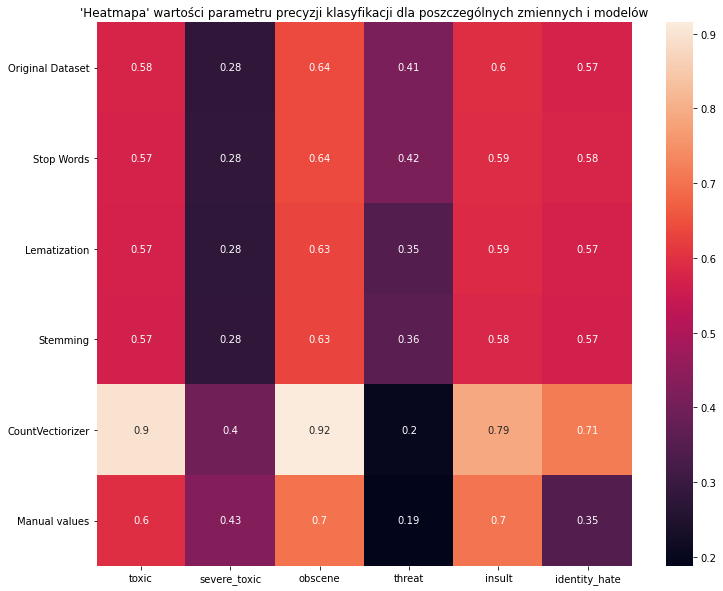

In [166]:
plt.figure(figsize=(12,10))
sns.heatmap(precision_df,
            yticklabels=precision_df.index.values,
            xticklabels=precision_df.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości parametru precyzji klasyfikacji dla poszczególnych zmiennych i modelów')
plt.show()

Najmniejsze wartości precyzji możemy zauważyć dla kategorii *severe_toxic* i *threat*. Z kolei porównując precyję modeli, poza klasą *threat* zdecydowanie najlepiej działa model oparty na **regresji logistycznej** i wektoryzacji tekstu za pomocą obiektu **CountVectorizer**. Dla tego modelu najwyższa wartość precyzji wystąpiła dla tekstu po zastosowaniu lematyzacji. 

### Wartość predykcyjna ujemna

$$Negative Predicitve Value =\frac{True Negative}{True Negative + False Negative}$$

Intuicyjnie wyraża prawdopodobieństwo, że ujemny wynik testu jest prawdziwy.

In [167]:
NPV = precision_df.copy()

In [168]:
NPV

,toxic,severe_toxic,obscene,threat,insult,identity_hate
Original Dataset,0.575830,0.280059,0.641943,0.413408,0.596487,0.572664
Stop Words,0.572954,0.282127,0.641243,0.415730,0.592620,0.579685
Lematization,0.568985,0.277126,0.632992,0.345946,0.585839,0.570962
Stemming,0.567963,0.279211,0.632560,0.361111,0.581989,0.567524
CountVectiorizer,0.896841,0.397849,0.915344,0.200000,0.788194,0.714286
Manual values,0.596646,0.430267,0.701042,0.187755,0.704583,0.345528


In [169]:
for i in range(6):
    NPV.iloc[0,i]=precision_score(y_test.iloc[:,i], basic_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[1,i]=precision_score(y_test.iloc[:,i], stop_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[2,i]=precision_score(y_test.iloc[:,i], lem_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[3,i]=precision_score(y_test.iloc[:,i], stem_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[4,i]=precision_score(y_test.iloc[:,i], lem2_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[5,i]=precision_score(y_test.iloc[:,i], lem3_pred[:,i], average='binary', pos_label=0)

In [170]:
NPV

,toxic,severe_toxic,obscene,threat,insult,identity_hate
Original Dataset,0.977196,0.997219,0.983567,0.997853,0.981948,0.993991
Stop Words,0.977317,0.997220,0.983810,0.997853,0.982232,0.993991
Lematization,0.979499,0.997188,0.984744,0.997696,0.983109,0.994287
Stemming,0.979615,0.997110,0.984743,0.997712,0.983117,0.994334
CountVectiorizer,0.924728,0.994834,0.955166,0.996717,0.953109,0.989025
Manual values,0.967953,0.996512,0.971566,0.997411,0.965400,0.990162


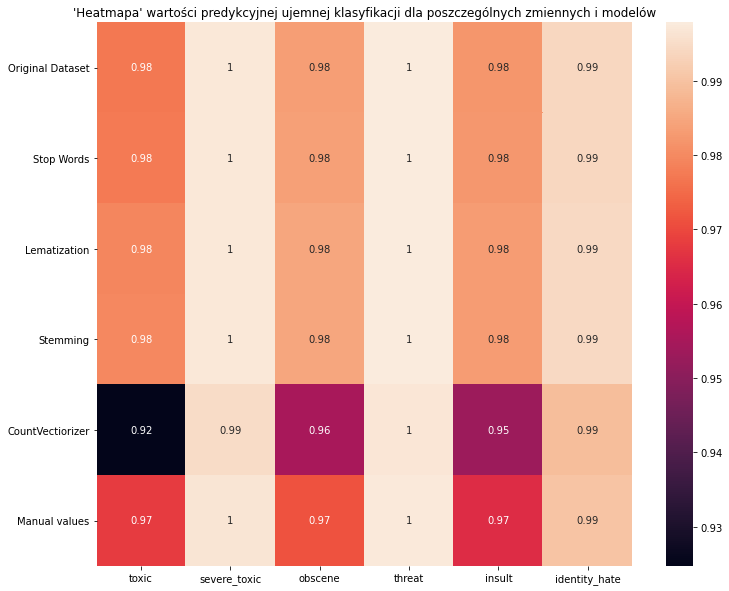

In [171]:
plt.figure(figsize=(12,10))
sns.heatmap(NPV,
            yticklabels=NPV.index.values,
            xticklabels=NPV.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości predykcyjnej ujemnej klasyfikacji dla poszczególnych zmiennych i modelów')
plt.show()

Negatywna wartość predykcyjna jest wysoka dla każdego modelu i dla każdej kategorii z tego względu, że dla każdej z klas dużo liczniejsza jest grupa do niej nienależąca niż ta reprezentująca daną klasę.

In [172]:
#F1_score, recall_score ... 

### Czułość

W przypadku danych niezrównoważonych miara trafności (*accuracy*) jest często złą miarą do oceny modelu. Badając efektywność działania modelu dla takich danych warto obliczyć czułość (*sensitivity*). Wyraża się ona wzorem:

$$Sensitivity =\frac{True Positive}{True Positive + False Negative}$$


In [173]:
recall = precision_df.copy()

In [174]:
for i in range(6):
    recall.iloc[0,i]=recall_score(y_test.iloc[:,i], basic_pred[:,i], average='binary')
    recall.iloc[1,i]=recall_score(y_test.iloc[:,i], stop_pred[:,i], average='binary')
    recall.iloc[2,i]=recall_score(y_test.iloc[:,i], lem_pred[:,i], average='binary')
    recall.iloc[3,i]=recall_score(y_test.iloc[:,i], stem_pred[:,i], average='binary')
    recall.iloc[4,i]=recall_score(y_test.iloc[:,i], lem2_pred[:,i], average='binary')
    recall.iloc[5,i]=recall_score(y_test.iloc[:,i], lem3_pred[:,i], average='binary')

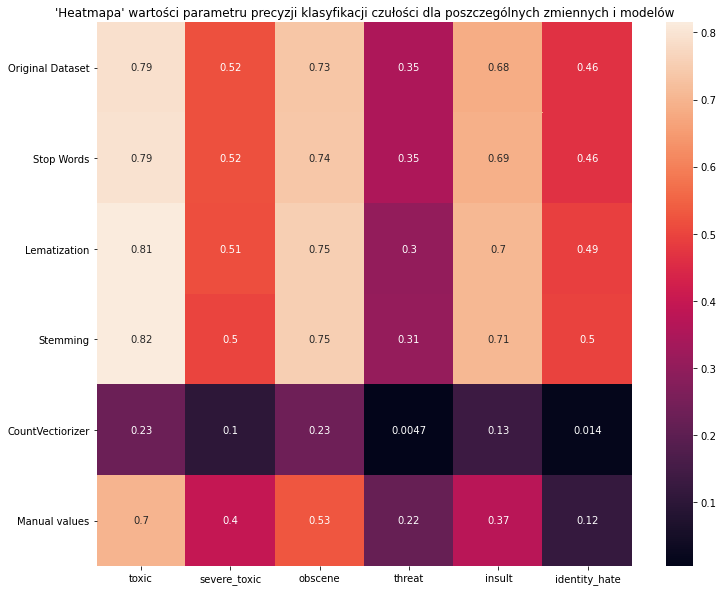

In [175]:
plt.figure(figsize=(12,10))
sns.heatmap(recall,
            yticklabels=recall.index.values,
            xticklabels=recall.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości parametru precyzji klasyfikacji czułości dla poszczególnych zmiennych i modelów')
plt.show()

Dla regresji logistycznej wartość parametru jest dosyć wysoka. Szczególnie warto zwrócić uwagę na poprawę wartości parametru dla zmiennych poddanych lematyzacji oraz stemmingowi.

### F1 score

Współczynnik F1 można zinterpretować jako średnia harmoniczną precyzji i czułości. Osiąga najlepszą wartość przy 1, a najgorszą przy 0. Względny wkład precyzji i czułości w wartość indeksu F1 jest taki sam. Współczynnik jest obliczany ze wzoru:

$$ Współczynnik F1 =2\cdot\frac{precyzja * czułość}{precyzja + czułość}$$


In [176]:
f1_basic = f1_score(y_test, basic_pred, average=None)
f1_stop = f1_score(y_test, stop_pred, average=None)
f1_lem = f1_score(y_test, lem_pred, average=None)
f1_stem = f1_score(y_test, stem_pred, average=None)
f1_lem2 = f1_score(y_test, lem2_pred, average=None)
f1_lem3 = f1_score(y_test,lem3_pred, average=None)

In [177]:
F1 = precision_df.copy()
F1.iloc[0,:] = f1_basic
F1.iloc[1,:] = f1_stop
F1.iloc[2,:] = f1_lem
F1.iloc[3,:] = f1_stem
F1.iloc[4,:] = f1_lem2
F1.iloc[5,:] = f1_lem3

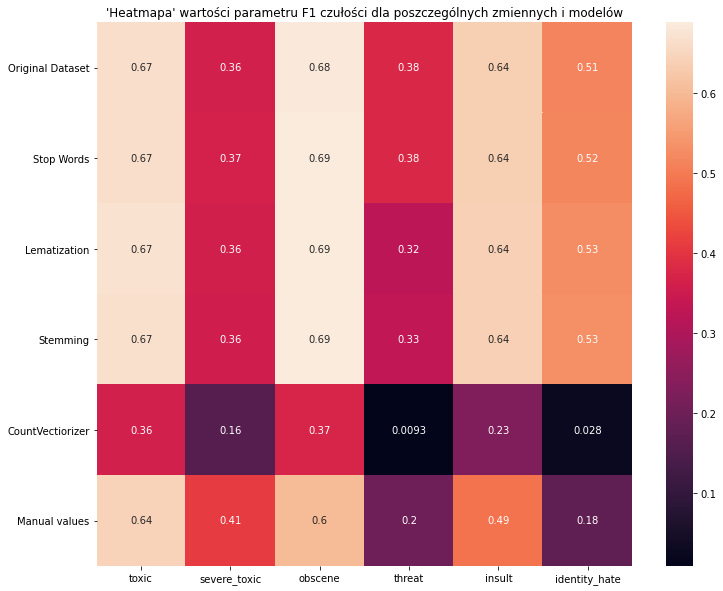

In [178]:
plt.figure(figsize=(12,10))
sns.heatmap(F1,
            yticklabels=F1.index.values,
            xticklabels=F1.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości parametru F1 czułości dla poszczególnych zmiennych i modelów')
plt.show()